In [1]:
import itertools
import tensorflow as tf
import pandas as pd
import numpy as np
import tqdm
import sys
# Local software setup
sys.path.append('..')

from tensorflow.keras.models import load_model
from scipy.spatial.distance import euclidean

from src.losses import custom_loss
from src.metrics import point_in_ellipse
from src.metrics import point_in_ellipse_numpy
from src.metrics import circle_area
from src.data_utils import sample_vertices
from src.data_utils import read_vertex_file

## Calculate metrics

In [2]:
path_to_model = "../data/models/tracknetv2_fix_epoch50_eff9593_hits9918_loss4030_pie9533_area4.3570.h5"
custom_objects = {
    "_tracknet_loss": custom_loss,
    "point_in_ellipse": point_in_ellipse,
    "circle_area": circle_area}

model = load_model(path_to_model, custom_objects=custom_objects)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [3]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, None, 4)      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 32)     416         inputs[0][0]                     
__________________________________________________________________________________________________
batch_norm (BatchNormalizationV (None, None, 32)     128         conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_relu (Activation)        (None, None, 32)     0           batch_norm[0][0]                 
__________________________________________________________________________________________________
gru1 (GRU)

## Events data

In [4]:
events = pd.read_csv('../data/test/CC4GeVmb_108_n50k.tsv', encoding='utf-8', sep='\t')

## Prepare first batch

In [5]:
vertex_stats = read_vertex_file("../data/train/fixed_vertex.json")
stations_z = [32.85, 65.25, 96.65, 129.35, 161.25, 193.85]

In [6]:
stations_sizes = [
    [[-1.5, -4.5, 66, 41]], 
    [[-1.5, -4.5, 66, 41]], 
    [[-1.5, -4.5, 66, 41]], 
    # module 0, module 1
    [[27.7, -4.5, 66, 31], [-34.7, -4.3, 66, 41]], 
    [[40.8, -6.9, 81.6, 45], [-40.8, -6.9, 66, 41]],
    [[40.8, -6.9, 81.6, 45], [-40.8, -6.9, 66, 41]]]


def get_extreme_points(xcenter,
                       ycenter,
                       width,
                       height):
    # width dependent measurements
    half_width = width / 2
    left = xcenter - half_width
    right = xcenter + half_width
    # height dependent measurements
    half_height = height / 2
    bottom = ycenter - half_height
    top = ycenter + half_height
    return (left, right, bottom, top)
    
    
def is_ellipse_intersects_module(ellipse_params,
                                 module_params):
    # calculate top, bottom, left, right
    ellipse_bounds = get_extreme_points(*ellipse_params)
    module_bounds = get_extreme_points(*module_params)
    # check conditions
    if ellipse_bounds[0] > module_bounds[1]:
        # ellipse left > rectangle rigth
        return False
    
    if ellipse_bounds[1] < module_bounds[0]:
        # ellipse rigth < rectangle left
        return False
    
    if ellipse_bounds[2] > module_bounds[3]:
        # ellipse bottom > rectangle top
        return False
    
    if ellipse_bounds[3] < module_bounds[2]:
        # ellipse top < rectangle bottom
        return False
    
    return True


def is_ellipse_intersects_station(ellipse_params,
                                  station_params):
    module_intersections = []
    for module in station_params:
        ellipse_in_module = is_ellipse_intersects_module(
            ellipse_params, module)
        # add to the list
        module_intersections.append(ellipse_in_module)
    return any(module_intersections)

In [7]:
def get_seeds_with_vertex(hits, vertex_stats):
    # first station hits
    st0_hits = hits[hits.station==0][['x', 'y', 'z']].values
    vertex = sample_vertices(vertex_stats, n=len(st0_hits))
    # create seeds
    seeds = np.zeros((len(st0_hits), 2, 4))
    seeds[:, 0, :-1] = vertex
    seeds[:, 1, :-1] = st0_hits
    seeds[:, :2, -1] = stations_z[:2]
    return seeds


def get_seeds(hits):
    st0_hits = hits[hits.station==0][['x', 'y', 'z']].values
    st1_hits = hits[hits.station==1][['x', 'y', 'z']].values
    # all possible combinations
    idx0 = range(len(st0_hits))
    idx1 = range(len(st1_hits))
    idx_comb = itertools.product(idx0, idx1)
    # unpack indices
    idx0, idx1 = zip(*idx_comb)
    idx0 = list(idx0)
    idx1 = list(idx1)
    # create seeds array
    seeds = np.zeros((len(idx0), 2, 4))
    seeds[:, 0, :-1] = st0_hits[idx0]
    seeds[:, 1, :-1] = st1_hits[idx1]
    seeds[:, :2, -1] = stations_z[1:3]
    return seeds

In [8]:
def reconstruct_event(hits, nn, n_stations=6, vertex_stats=None):
    # next station
    st = 1
    j = 2
    short_tracks = []
    
    # prepare seeds
    if vertex_stats is None:
        st = 2
        seeds = get_seeds(hits)
        batch_xs = np.zeros((len(seeds), n_stations, 4))
        batch_shape = (len(seeds), n_stations, 4)
    else:
        seeds = get_seeds_with_vertex(hits, vertex_stats)
        batch_shape = (len(seeds), n_stations+1, 4)
        
    # seeds to the batch
    batch_xs = np.zeros(batch_shape, dtype=np.float32)
    batch_xs[:, :2] = seeds
    
    while st < n_stations:
        y_pred = nn.predict(batch_xs)
        batch_xs_new = []
        for i, ellipse in enumerate(y_pred):
            # ellipse intersection doesn't work!!!
            next_hits = hits[hits.station==st][['x', 'y', 'z']]
            next_hits = next_hits.values.astype('float32')
            ellipses = np.repeat([ellipse], len(next_hits), axis=0)
            mask = point_in_ellipse_numpy(next_hits, ellipses)
            masked_hits = next_hits[mask]
            extensions = np.zeros((len(masked_hits), batch_xs.shape[1], 4))
            extensions[:] = batch_xs[i:i+1]
            extensions[:, j, :-1] = masked_hits
            
            if st < n_stations-1:
                # for the last row we have not next z
                extensions[:, j, -1] = stations_z[st+1]
                
            # add to the result array
            batch_xs_new.extend(extensions)
            
        if len(batch_xs_new) == 0:
            print('Alert!!!')
            break
            
        # prepare for the next iteration
        batch_xs = np.asarray(batch_xs_new)
        st += 1
        j += 1
        
    if len(short_tracks) > 0:
        batch_xs = np.vstack([batch_xs, short_tracks])
    
    if batch_xs.shape[1] > n_stations:
        # remove vertex and z+1
        return batch_xs[:, 1:, :-1]
    # only remove z+1
    return batch_xs[:, :, :-1]

In [55]:
def event_efficiency(event, reco_tracks):
    correct = 0
    groupby_obj = event[event.track != -1].groupby('track')
    # reshape to calculate squared distance
    reco_tracks = reco_tracks.reshape(len(tracks), -1)
    
    for i, gp in groupby_obj:
        true_track = np.zeros((1, 6, 3))
        track_hits = gp[['x', 'y', 'z']].values
        true_track[0, :len(track_hits)] = track_hits
        true_track = true_track.reshape(1, -1)

        dist = np.linalg.norm(true_track-reco_tracks, axis=1)
        min_dist = dist.min()

        if min_dist < 1:
            correct += 1
            continue

    recall = correct / groupby_obj.ngroups
    precision = correct / len(reco_tracks)
    return recall, precision

In [57]:
event_ids = []
recalls = []
precisions = []
events_gp = events.groupby('event')

try:
    for event_id, event in tqdm.tqdm_notebook(events_gp):
        tracks = reconstruct_event(event, model, vertex_stats=vertex_stats)
        recall, precision = event_efficiency(event, tracks)
        recalls.append(recall)
        precisions.append(precision)
        event_ids.append(event_id)
except KeyboardInterrupt:
    print("KeyboardInterrupt")

Alert!!!
Alert!!!
Alert!!!
Alert!!!
Alert!!!
Alert!!!
Alert!!!
Alert!!!
Alert!!!
Alert!!!
Alert!!!
Alert!!!
Alert!!!
Alert!!!
Alert!!!
Alert!!!
Alert!!!
Alert!!!
Alert!!!
Alert!!!
Alert!!!
Alert!!!
Alert!!!
Alert!!!
Alert!!!
Alert!!!
Alert!!!
Alert!!!
Alert!!!
Alert!!!
Alert!!!
Alert!!!
Alert!!!
Alert!!!
Alert!!!
Alert!!!
Alert!!!
Alert!!!
KeyboardInterrupt


In [64]:
print('Recall: %.4f' % np.mean(recalls))
print('Precision: %.4f' % np.mean(precisions))
print('Ghost rate: %.4f' % (1-np.mean(precisions)))

Recall: 0.7879
Precision: 0.6611
Ghost rate: 0.3389


In [65]:
np.savez('stats.npz', recall=recalls, precision=precisions)

## Visualize errors

In [66]:
import matplotlib.pyplot as plt

In [67]:
metrics = np.load('stats.npz')
N = len(metrics['recall'])

In [91]:
['%.1f' % x for x in vals]

['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']

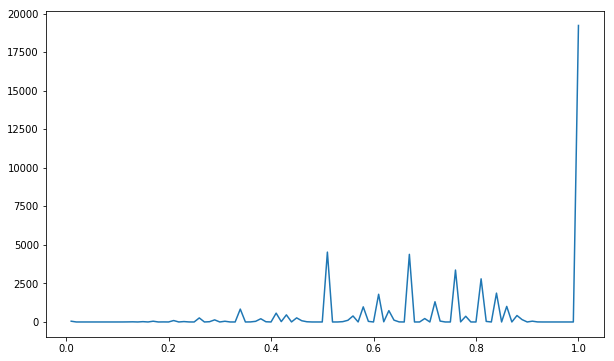

In [106]:
fig, ax = plt.subplots(figsize=(10, 6))
weights, vals = np.histogram(metrics['recall'], bins=100)
ax.plot(vals[1:], weights)
plt.show()

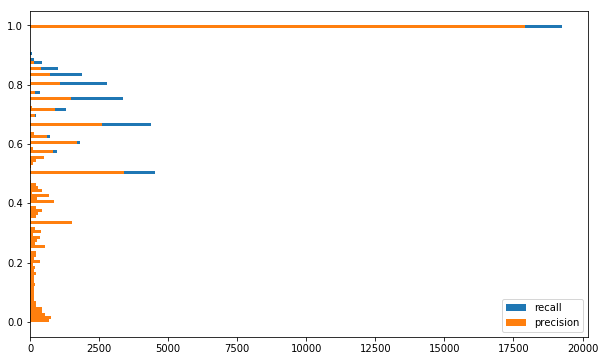

In [117]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(metrics['recall'], bins=100, orientation='horizontal')
ax.hist(metrics['precision'], bins=100, orientation='horizontal')

plt.legend(['recall', 'precision'])
plt.show()

In [47]:
clean_df = events[events.track != -1]
clean_df = clean_df[clean_df.event < N]
gp = clean_df.groupby(['event'])
gp_size = gp.track.value_counts()

In [48]:
gp_size

event  track
0      2        6
       3        6
       5        6
       9        6
       11       6
       6        4
1      1        6
       2        6
2      13       6
       14       6
       11       5
       5        3
3      11       6
       16       6
       26       6
       27       6
       29       6
       31       6
       42       6
       4        5
       23       5
       3        4
       22       4
       33       4
       28       3
7      2        6
       4        6
       21       6
       24       6
       26       6
               ..
5006   0        6
       2        6
       5        6
       6        6
       8        6
       11       6
       17       6
       7        3
5007   9        6
       11       6
       12       6
       7        5
5008   6        6
       5        3
5009   0        6
       5        6
       6        6
       7        6
5010   0        6
       8        6
       19       6
       20       6
       6        5
       10      